# 2. Create surfaces from data points

Subsurface Hackathon 2017, Paris.

*Joseph Barraud and Martin Bentley*

---
This notebook describes the work that was conducted by our team during the [Subsurface Hackathon in Paris](https://agilescientific.com/paris/) (10-11 June 2017). 

This is the second step of a typical workflow that can be used with this sort of data, i.e. groundwater levels measurements at well locations. Please see the [first notebook](.\1. Levels data loading.ipynb) for an introduction about the data.

In [1]:
import os
import numpy as np
import matplotlib as mpl
from scipy import interpolate
import matplotlib.pyplot as plt
import pandas as pd
% matplotlib inline

### Options

The images generated in this notebook have a transparent background. Unfortunately, when you try and copy those images and paste them into a program like PowerPoint, you will get a black background instead.

The following change fixes this problem.

In [2]:
# matplotlib options
mpl.rcParams['figure.facecolor'] = 'white'

In [3]:
# pandas options
pd.options.display.max_rows = 6

## Data loading

The data were previously imported from csv files into a pandas dataframe (see [first notebook](.\1. Levels data loading.ipynb)).

In [4]:
# load file
all_depths = pd.read_pickle(r'..\data\Groundwater-Levels\all_depths_v1.pkl.gz')

## Plotting

The obvious way to visualise the data is to make a map of well locations. The data are in a pandas dataframe so it is easy to use the `plot.scatter` method for creating such a plot. However, I found out using this method that there is a bug that prevents the display of the labels on the x-axis (see the end of the first notebook). The second problem is that the axes have different scales, which makes the map look distorted. 

To get better control on the look of the plot, I therefore prefer to use the matplotlib function for scatter plots (which is the one called by the pandas function anyway).

Let's start by plotting the average water level at each well.

In [5]:
# mean depth at screen 1 ("filter nummer")
means1 = all_depths.loc[(slice(None),1),:].mean(level=[0,1])
means1

,,depth,x,y
well,screen,,,
B24F0005,1,322.056017,99680,493440
B24F0028,1,154.272727,98170,491310
B24F0029,1,3.272468,99590,487860
...,...,...,...,...
B25F0328,1,-152.634615,130540,492480
B25F0329,1,-183.320000,130580,492525
B25G0519,1,-300.272997,120516,485658


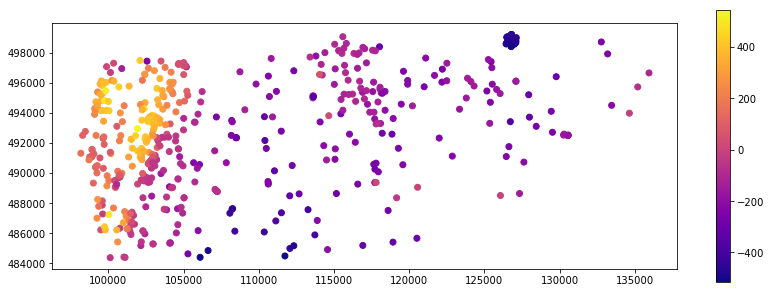

In [6]:
fig,ax = plt.subplots(figsize=(14,10))
pts = ax.scatter(means1.x,means1.y,c=means1.depth, cmap='plasma')
ax.set_aspect('equal')
plt.colorbar(pts, shrink=0.5)

The depth is relative to the Normaal Amsterdams Peil (NAP), so it can be positive or negative. We can change the color map to better reflect this type of data. By using the reversed "coolwarm" colormap, the shallowest levels are now in red, and the deepest ones in blue.

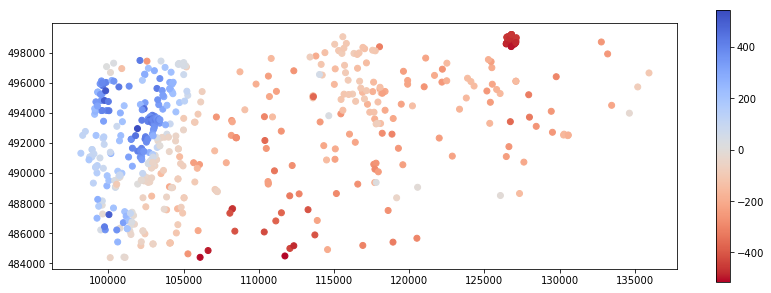

In [7]:
fig,ax = plt.subplots(figsize=(14,10))
pts = ax.scatter(means1.x,means1.y,c=means1.depth, cmap='coolwarm_r')
ax.set_aspect('equal')
plt.colorbar(pts, shrink=0.5)

## Gridding

Gridding the scatterred points onto a regular grid to obtain a continuous surface is possible with the `griddata` function of the `scipy.interpolate` module.

First, we need to extract the coordinates of the wells and the depths into two separate variables. Note that we don't need to convert them to numpy arrays, they can stay as pandas object, i.e. points in a dataframe and values in a series.

In [8]:
points = means1[['x','y']]
values = means1.depth

Next, we need to create the grids (or arrays) that are going to define our surface. We need two arrays, one for each coordinates (x and y).

So the next task is actually to identify the range of x and y coordinates of our well data.

In [9]:
x_min = all_depths.x.min()
x_max = all_depths.x.max()
y_min = all_depths.y.min()
y_max = all_depths.y.max()

The surface is defined by its dimensions and its cell size. I am adding some padding (two cell sizes) to obtain a surface that is slightly bigger than the minimum bounding box around the wells.

In [10]:
cellsize = 100
vector_x = np.arange(x_min-2*cellsize, x_max+3*cellsize, cellsize)
vector_y = np.arange(y_min-2*cellsize, y_max+3*cellsize, cellsize)
grid_x, grid_y = np.meshgrid(vector_x,vector_y)

`meshgrid` has created a set of two arrays that contain the coordinates of all the points in the grid. For the y coordinate for example, the vector of y values is repeated identically for each x coordinate.

In [11]:
grid_y

array([[484168, 484168, 484168, ..., 484168, 484168, 484168],
       [484268, 484268, 484268, ..., 484268, 484268, 484268],
       [484368, 484368, 484368, ..., 484368, 484368, 484368],
       ..., 
       [499268, 499268, 499268, ..., 499268, 499268, 499268],
       [499368, 499368, 499368, ..., 499368, 499368, 499368],
       [499468, 499468, 499468, ..., 499468, 499468, 499468]], dtype=int64)

However, note how the y coordinates increase from top to bottom. This is incorrect because we know y coordinates increase from south to north. This can be easily fixed by flipping the array upside down by using the numpy function `flipud`.

It's now time to run the interpolation function to "grid" the data. There are several methods available. Let's try first with the simplest one, *nearest* neighbours.

In [12]:
grid1 = interpolate.griddata(points, values, (grid_x, np.flipud(grid_y)), method='nearest')

We can see how the result looks like with pyplot's function `imshow`.

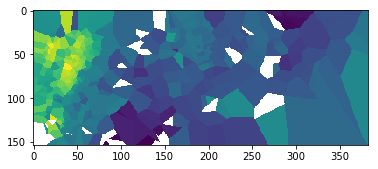

In [13]:
plt.imshow(grid1)

We can do several things to improve this map: add the locations of the wells and add a colorbar.

Adding the wells is only possible if the grid is plotted in its correct geographical location: this means we need to compute the true extent of the grid and provide it to `imshow`.

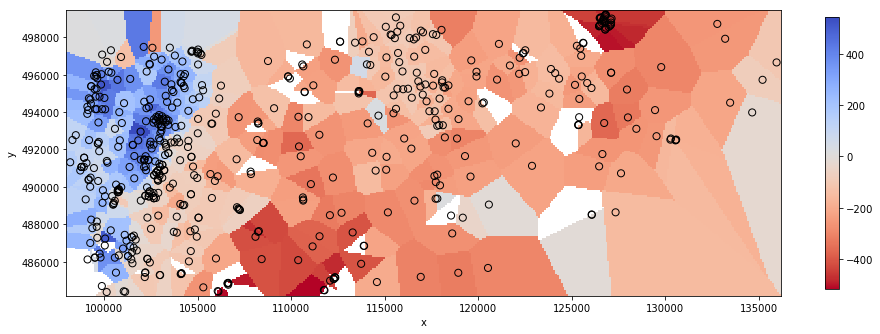

In [14]:
# calculate extent of the grid
extent1 = (vector_x.min(),vector_x.max(), vector_y.min(), vector_y.max())
# make a map with wells as dots
fig,ax = plt.subplots(figsize=(16,10))
plt.imshow(grid1,extent=extent1, cmap='coolwarm_r')
means1.plot.scatter(x='x',y='y', c='none',edgecolors='k', s=50, ax=ax, colorbar=False)
plt.colorbar(shrink=0.5)

The white gaps in the surface are due to the absence of depth data (NaNs) at a few locations. These empty points can be removed with the `dropna` method in pandas.

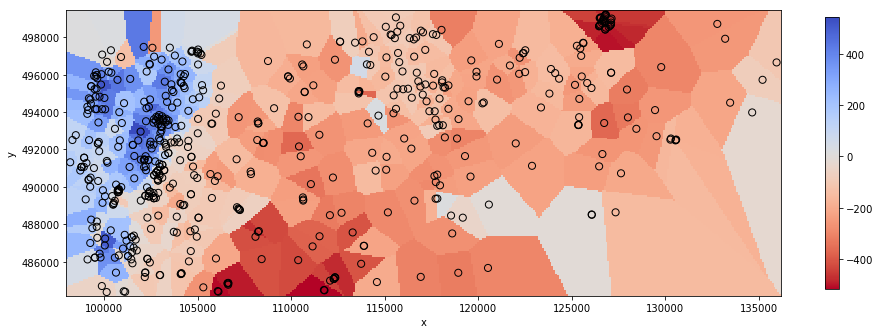

In [15]:
# new interpolation by removing null data first, the dimensions of the grid are unchanged.
means2 = all_depths.loc[(slice(None),1),:].dropna().mean(level=[0,1])
points = means2[['x','y']]
values = means2.depth
grid2 = interpolate.griddata(points, values, (grid_x, np.flipud(grid_y)), method='nearest')
# make a map with wells as dots
fig,ax = plt.subplots(figsize=(16,10))
plt.imshow(grid2,extent=extent1, cmap='coolwarm_r')
means1.plot.scatter(x='x',y='y', c='none',edgecolors='k', s=50, ax=ax, colorbar=False)
plt.colorbar(shrink=0.5)

Finally, we can try a different method for the interpolation and see the effect.

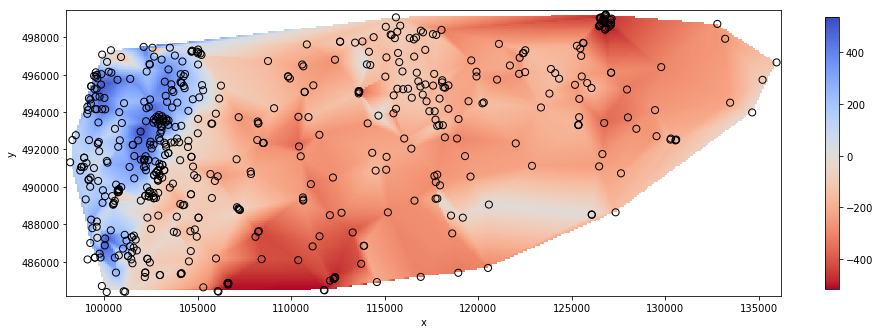

In [16]:
# new interpolation with the "linear" method (same points).
grid3 = interpolate.griddata(points, values, (grid_x, np.flipud(grid_y)), method='linear')
# make a map with wells as dots
fig,ax = plt.subplots(figsize=(16,10))
plt.imshow(grid3,extent=extent1, cmap='coolwarm_r')
means1.plot.scatter(x='x',y='y', c='none',edgecolors='k', s=50, ax=ax, colorbar=False)
plt.colorbar(shrink=0.5)

## Resample in time

Interpolating a surface between points at various depths is a kind of resampling exercise: we now have a grid of equally spaced points where we "know" the water depth, while before we had an uneven distribution of points and large gaps in our knowledge.

The same approach can be applied to the fourth dimension, time. Measurements have been made at regular intervals, roughly every two weeks but there are gaps in the timeline. More importantly, the depth is not measured at the same time at all the well locations. This points to a major flaw in our previous result: the mean depth was calculated for each well, irrespective of the time span these measurements actually cover. Some wells have been active only in the 60's, others only in the 80's; therefore it does not make sense to put them all in the same bag to create a single surface.

A great improvement to our surface creation tool would be to use only the wells that have an actual depth measurement at a given date. So we could do a selection based on a particular day. However, we might not get a good number of points. A more clever approach would be to resample the data to a fixed period of time, say monthly, so that we get a maximum of wells for each month. That's why this process is called *aggregation*. By doing so, we also assume that the water depth does not vary too much at higher frequencies than our new sampling rate. In other words, we are losing *some* information in the process, but we hope it is not too significant.

Let's see how to aggregate statistics in time. It's very easy with the pandas function `resample`.

In [17]:
# make a selection of wells with depths at screen 1 only
all_depths1 = all_depths.loc[(slice(None),1),:].reset_index(1, drop=True)
all_depths1

depth       x       y
well     date                             
B24F0005 1956-01-17  347.0   99680  493440
         1956-03-21  366.0   99680  493440
         1956-04-18  357.0   99680  493440
...                    ...     ...     ...
B25G0519 1996-10-21 -281.0  120516  485658
         1996-11-14 -285.0  120516  485658
         1996-11-19 -265.0  120516  485658

[362164 rows x 3 columns]

Resampling must be applied to each well separately, so initial grouping is necessary. 

The new period will be one month and we want to have new values at the beginning of each month ("Month Start" or MS). We could choose something else and a large choice of aliases for useful periods (or *offets*) are available from this [list](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases).

The `resample` function works together with a statistical function, here we simply use the mean.

In [18]:
all_depths1_permonth = all_depths1.reset_index(0).groupby('well').resample('MS').mean()
all_depths1_permonth

depth         x         y
well     date                                 
B24F0005 1956-01-01  347.0   99680.0  493440.0
         1956-02-01    NaN       NaN       NaN
         1956-03-01  366.0   99680.0  493440.0
...                    ...       ...       ...
B25G0519 1996-09-01 -277.0  120516.0  485658.0
         1996-10-01 -281.0  120516.0  485658.0
         1996-11-01 -275.0  120516.0  485658.0

[118562 rows x 3 columns]

Now we can plot water level variations versus time for each well.

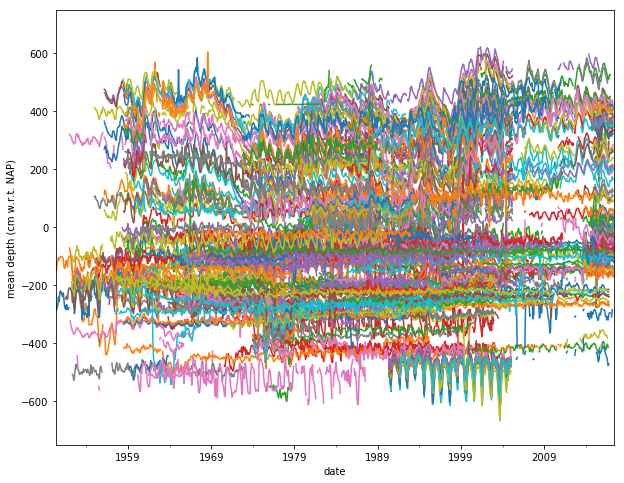

In [19]:
grouped = all_depths1_permonth.reset_index(0).groupby('well')
fig, ax = plt.subplots(figsize=(10,8))

for name, group in grouped:
    group.depth.plot(ax=ax)
ax.set_ylabel('mean depth (cm w.r.t. NAP)')
ax.set_ylim(-750,750);

We can clearly see some seasonal variations.

Here is another example using the minimum value over a yearly period.

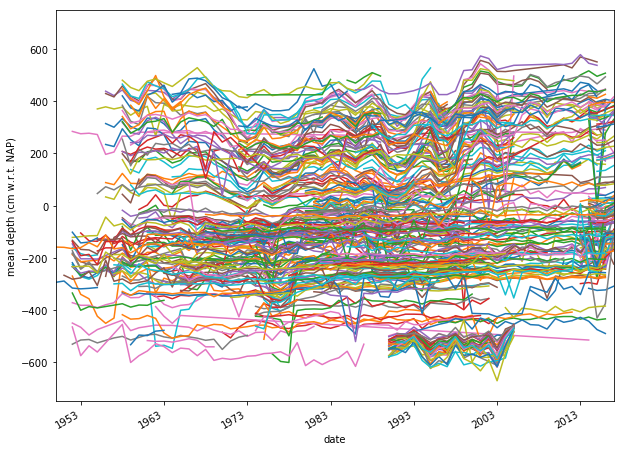

In [20]:
all_depths1_peryear = all_depths1.reset_index(0).groupby('well').resample('AS').min()
grouped = all_depths1_peryear.reset_index(0,drop=True).groupby('well')
# plot
fig, ax = plt.subplots(figsize=(10,8))
for name, group in grouped:
    group.depth.plot(ax=ax)
ax.set_ylabel('mean depth (cm w.r.t. NAP)')
ax.set_ylim(-750,750);

Finally, we can pick up a date and create a water level surface based on data from that time only.

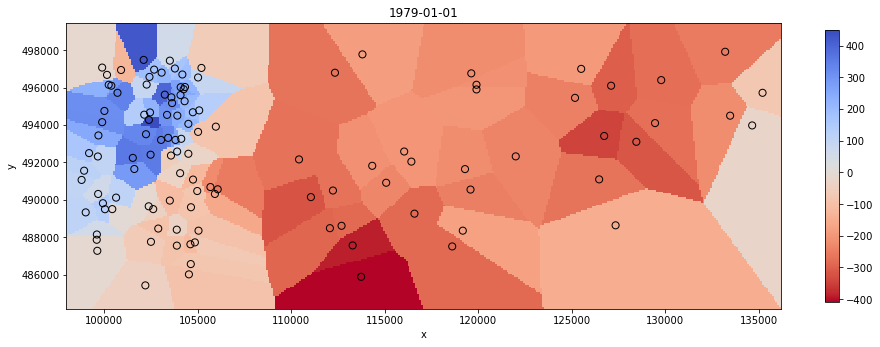

In [21]:
# select data for a given month
date = '1979-01-01'
dfa = all_depths1_permonth.loc[(slice(None),date),:].dropna()
# grid the data
points = dfa[['x','y']]
values = dfa.depth
grid4 = interpolate.griddata(points, values, (grid_x, np.flipud(grid_y)), method='nearest')
# plot the surface
fig,ax = plt.subplots(figsize=(16,10))
plt.imshow(grid4,extent=extent1, cmap='coolwarm_r')
dfa.plot.scatter(x='x',y='y', c='none',edgecolors='k', s=50, ax=ax, colorbar=False)
plt.colorbar(shrink=0.5)
ax.set_title(date)

Another example:

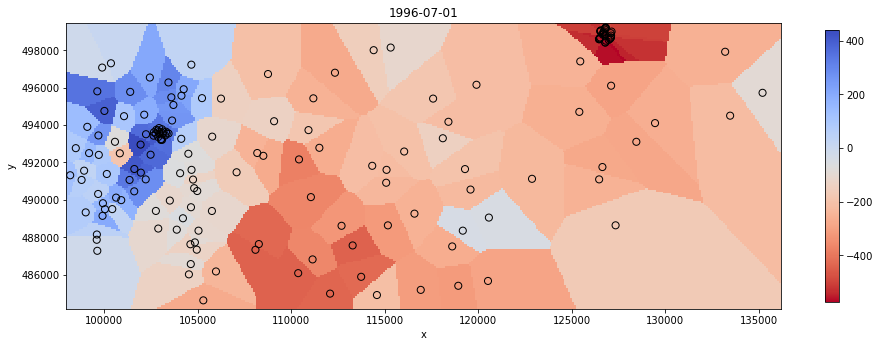

In [22]:
# select data for a given month
date = '1996-07-01'
dfa = all_depths1_permonth.loc[(slice(None),date),:].dropna()
# grid the data
points = dfa[['x','y']]
values = dfa.depth
grid4 = interpolate.griddata(points, values, (grid_x, np.flipud(grid_y)), method='nearest')
# plot the surface
fig,ax = plt.subplots(figsize=(16,10))
plt.imshow(grid4,extent=extent1, cmap='coolwarm_r')
dfa.plot.scatter(x='x',y='y', c='none',edgecolors='k', s=50, ax=ax, colorbar=False)
plt.colorbar(shrink=0.5)
ax.set_title(date)

In the final notebook, we will see how we can make these plots interactive by using the `ipywidgets` library.